In [ ]:
#https://github.com/guilhermedom/cnn-fashion-mnist/blob/main/notebooks/1.0-gdfs-cnn-fashion-mnist.ipynb
#https://github.com/zubairsamo/Fashion-Mnist-Using-CNN

In [22]:
%pip install tensorflow
%pip install scikit-learn
%pip install scipy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from sklearn.utils import resample
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import t

In [3]:
# Load the MNIST Fashion dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
# Normalize pixel values to be between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape images to 3D tensors (height, width, channels)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [5]:
# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

/Users/alanzhang/Library/Python/3.10/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [6]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# Train the model
epochs = 10
history = model.fit(train_images, train_labels, epochs, validation_data=(test_images, test_labels), verbose=2)
train_acc = history.history['accuracy']
print('Train accuracy:', train_acc[-1])

6000/6000 - 39s - 7ms/step - accuracy: 0.9416 - loss: 0.1548 - val_accuracy: 0.9037 - val_loss: 0.3293
Train accuracy: 0.9415500164031982


In [8]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.912


In [14]:
def get_margin_of_error(test_acc, accuracy_results, n_iterations):
    # Compute confidence intervals
    p_value = (np.sum(np.array(accuracy_results) >= test_acc) + 1) / (n_iterations + 1)

    print("p-value:", p_value)

    alpha = 0.05
    z_score = stats.norm.ppf(1 - alpha / 2)

    # Compute the standard error of the permutation test accuracies
    std_error = np.std(accuracy_results) / np.sqrt(n_iterations)

    # Compute the margin of error
    margin_of_error = z_score * std_error

    # Calculate the lower and upper bounds of the confidence interval
    lower_bound = test_acc - margin_of_error
    upper_bound = test_acc + margin_of_error

    print("p-value:", p_value)
    print("95% Confidence Interval:", (lower_bound, upper_bound))
    return margin_of_error

In [15]:
# Mini-batch Bootstrap resampling for confidence interval estimation
n_iterations = 10
batch_size = 128  # Adjust batch size as needed
accuracy_results = []

for _ in range(n_iterations):
    print(f'Iteration {_ + 1}/{n_iterations}')
    # Randomly select indices for the mini-batch
    indices = np.random.choice(train_images.shape[0], size=100, replace=True)
    indices_tensor = tf.convert_to_tensor(indices)  # Convert numpy array to tensor
    resampled_images = tf.gather(train_images, indices_tensor)
    resampled_labels = tf.gather(train_labels, indices_tensor)

    permuted_train_labels = np.random.permutation(resampled_labels)
    
    model.fit(resampled_images, permuted_train_labels, epochs=10, verbose=0)
    
    # Evaluate model on test data
    _, acc = model.evaluate(test_images, test_labels, verbose=0)
    accuracy_results.append(acc)  # Append accuracy value to the list
    print(f'ccuracy: {acc:.3f}')

train_margin_of_error = get_margin_of_error(train_acc, accuracy_results, n_iterations)

test_margin_of_error = get_margin_of_error(test_acc, accuracy_results, n_iterations)

print('train_margin_of_error:', train_margin_of_error)
print('test_margin_of_error:', test_margin_of_error)


Iteration 1/10
ccuracy: 0.090
Iteration 2/10
ccuracy: 0.090
Iteration 3/10
ccuracy: 0.087
Iteration 4/10
ccuracy: 0.103
Iteration 5/10
ccuracy: 0.164
Iteration 6/10
ccuracy: 0.112
Iteration 7/10
ccuracy: 0.140
Iteration 8/10
ccuracy: 0.124
Iteration 9/10
ccuracy: 0.128
Iteration 10/10
ccuracy: 0.125
p-value: 0.09090909090909091
p-value: 0.09090909090909091
95% Confidence Interval: (0.945125031949735, 0.9743083233816859)
p-value: 0.09090909090909091
p-value: 0.09090909090909091
95% Confidence Interval: (0.8972083811776402, 0.9263916726095912)
train_margin_of_error: 0.014591645715975479
test_margin_of_error: 0.014591645715975479


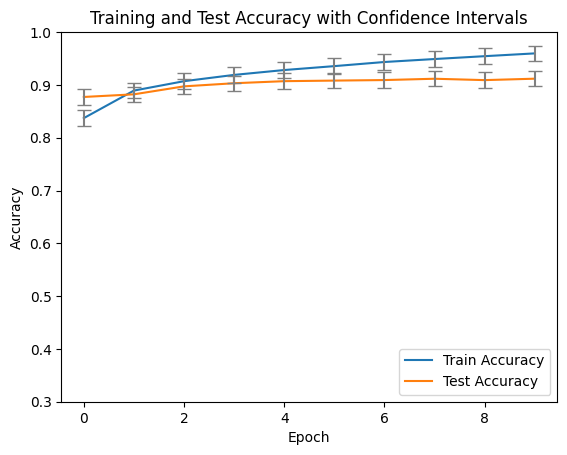

In [16]:
# Plot training and test accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')


# Plot confidence intervals
for epoch, (train_acc, test_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy'])):
    plt.errorbar(epoch, train_acc, yerr=train_margin_of_error, fmt='none', ecolor='gray', capsize=5)
    plt.errorbar(epoch, test_acc, yerr=test_margin_of_error, fmt='none', ecolor='gray', capsize=5)

plt.title('Training and Test Accuracy with Confidence Intervals')
plt.show()

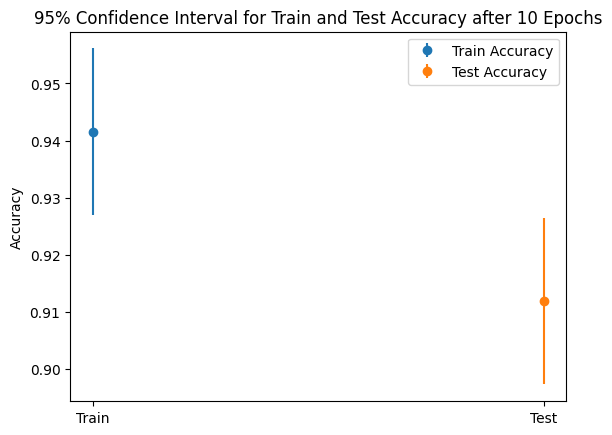

In [20]:
# plot both train and test confidence intervals
plt.errorbar(x=0, y=train_acc, yerr=train_margin_of_error, fmt='o', label='Train Accuracy')
plt.errorbar(x=1, y=test_acc, yerr=test_margin_of_error, fmt='o', label='Test Accuracy')
plt.xticks([0, 1], ['Train', 'Test'])
plt.ylabel('Accuracy')
plt.title('95% Confidence Interval for Train and Test Accuracy after ' + str(epochs) + ' Epochs')
plt.legend()

plt.show()